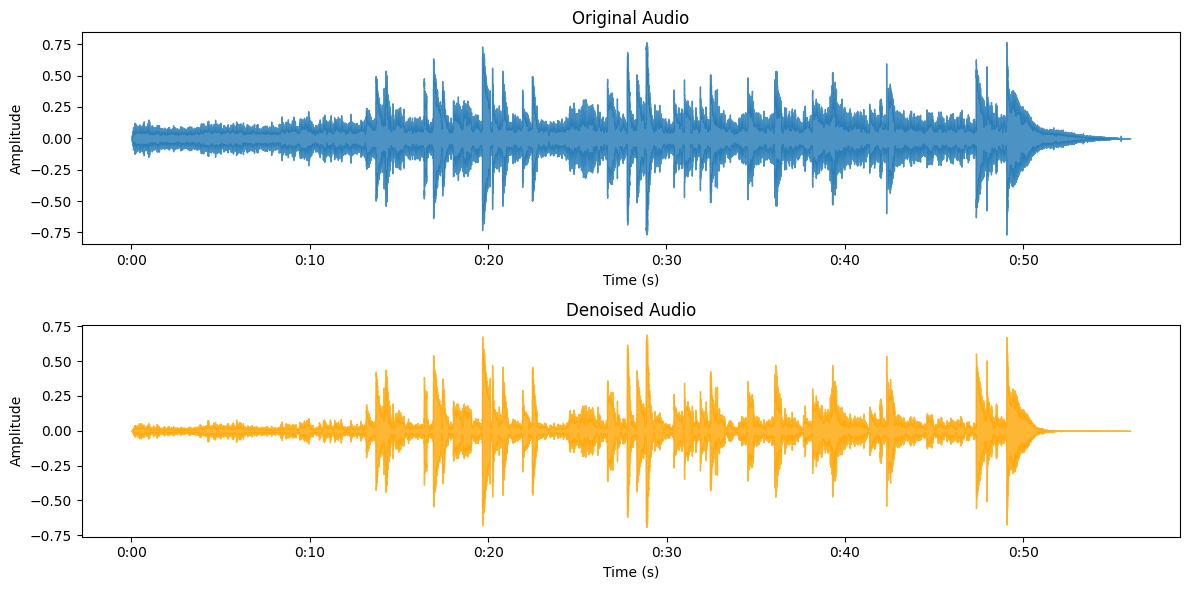

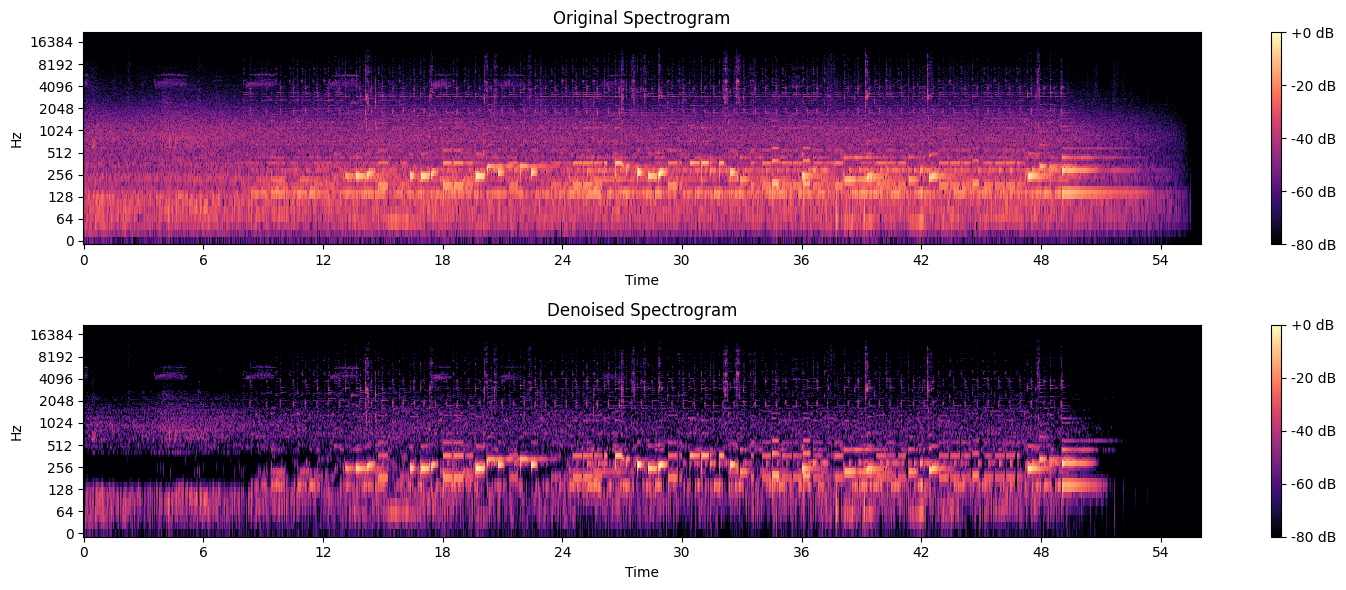

Metrics: {'SNR (dB)': 8.690299197709127, 'Spectrogram Energy Difference': 12336483.0}
Denoising complete. Output saved to 'denoised_audio.wav'.


In [9]:

import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt

def estimate_noise(audio, sr, n_fft=2048, hop_length=512, t=90):

    # computes STFT
    stft_audio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft_audio)

    # calculates frame energy
    frame_energy = np.sum(magnitude**2, axis=0)

    # selects low-energy frames as noise
    low_energy_threshold = np.percentile(frame_energy, t)  # Lowest t% frames
    noise_frames = magnitude[:, frame_energy <= low_energy_threshold]

    # estimates noise profile (average of low-energy frames)
    noise_profile = np.mean(noise_frames, axis=1, keepdims=True)
    return noise_profile

def stft_denoise_auto(audio, sr, n_fft=2048, hop_length=512, t=90):

    # estimates noise
    noise_profile = estimate_noise(audio, sr, n_fft, hop_length, t)

    # compute STFT
    stft_audio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = np.abs(stft_audio), np.angle(stft_audio)

    # subtract noise profile
    magnitude_denoised = magnitude - noise_profile
    magnitude_denoised[magnitude_denoised < 0] = 0  # Clamp to zero

    # reconstruct the signal using inverse STFT
    stft_denoised = magnitude_denoised * np.exp(1j * phase)
    denoised_audio = librosa.istft(stft_denoised, hop_length=hop_length)
    return denoised_audio


def smooth_audio(audio, window_size=5):
    if window_size < 1:
        raise ValueError("Window size must be greater than or equal to 1")

    # Apply moving average
    smoothed_audio = np.convolve(audio, np.ones(window_size) / window_size, mode='same')
    return smoothed_audio

# plots waveforms
def plot_waveforms(original, denoised, sr):

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original, sr=sr, alpha=0.8)
    plt.title("Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(denoised, sr=sr, alpha=0.8, color='orange')
    plt.title("Denoised Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# computes metrics
def compute_metrics(original, denoised, sr):

    # ensures the signals are the same length
    min_length = min(len(original), len(denoised))
    original = original[:min_length]
    denoised = denoised[:min_length]

    # computes noise signal and snr
    noise = original - denoised
    snr = 10 * np.log10(np.sum(original**2) / (np.sum(noise**2) + 1e-8))

    # spectrogram energy difference
    original_stft = librosa.stft(original)
    denoised_stft = librosa.stft(denoised)
    spectrogram_diff = np.sum(np.abs(original_stft)**2 - np.abs(denoised_stft)**2)

    return {
        "SNR (dB)": snr,
        "Spectrogram Energy Difference": spectrogram_diff,
    }



def plot_spectrograms(original, denoised, sr, n_fft=2048, hop_length=512):

    # compute STFT for original and denoised to plot
    stft_original = librosa.stft(original, n_fft=n_fft, hop_length=hop_length)
    stft_denoised = librosa.stft(denoised, n_fft=n_fft, hop_length=hop_length)

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_original), ref=np.max),
                             sr=sr, x_axis='time', y_axis='log')
    plt.title("Original Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_denoised), ref=np.max),
                             sr=sr, x_axis='time', y_axis='log')
    plt.title("Denoised Spectrogram")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()


audio_path = "intro.wav"  # Replace with your file path
audio, sr = librosa.load(audio_path, sr=None)

# apply automatic denoising
denoised_audio = stft_denoise_auto(audio, sr)

smoothed_audio = smooth_audio(denoised_audio, window_size=10)

# save smoothed audio
sf.write("smoothed_denoised_audio.wav", smoothed_audio, sr)

# visualization
plot_waveforms(audio, denoised_audio, sr)
plot_spectrograms(audio, denoised_audio, sr)

metrics = compute_metrics(audio, denoised_audio, sr)
print("Metrics:", metrics)


In [3]:
# Additional numerical methods for denoising

# denoise audio using spectral gating with smoothing.
def spectral_gate_denoise(stft_matrix, noise_estimate, reduction_factor=0.7, smoothing_factor=0.8):

    magnitude, phase = np.abs(stft_matrix), np.angle(stft_matrix)

    # compute dynamic noise threshold for each frame
    dynamic_threshold = noise_estimate * reduction_factor

    # apply a soft threshold to suppress magnitudes below it
    denoised_magnitude = np.where(
        magnitude > dynamic_threshold,
        magnitude - dynamic_threshold,
        0
    )

    # smooth the magnitude spectrogram
    smoothed_magnitude = np.copy(denoised_magnitude)
    for t in range(1, denoised_magnitude.shape[1]):
        smoothed_magnitude[:, t] = (
            smoothing_factor * smoothed_magnitude[:, t - 1]
            + (1 - smoothing_factor) * denoised_magnitude[:, t]
        )

    # reconstruct the STFT with smoothed magnitudes and original phase
    denoised_stft = smoothed_magnitude * np.exp(1j * phase)
    return denoised_stft


In [4]:
def wiener_filter_denoise(stft_matrix, noise_estimate, beta=1.0):

    magnitude, phase = np.abs(stft_matrix), np.angle(stft_matrix)

    # compute power spectra
    signal_power = magnitude**2
    noise_power = noise_estimate**2

    # compute Wiener gain (SNR-dependent)
    gain = signal_power / (signal_power + beta * noise_power)

    # apply gain to magnitude
    denoised_magnitude = gain * magnitude

    # reconstruct the STFT with original phase
    denoised_stft = denoised_magnitude * np.exp(1j * phase)
    return denoised_stft


In [8]:
# Load audio file
audio_path = "intro.wav"  # Replace with your file path
audio, sr = librosa.load(audio_path, sr=None)

# Compute the STFT of the input audio
stft_matrix = librosa.stft(audio, n_fft=2048, hop_length=512)

# Estimate noise using initial frames
noise_estimate = estimate_noise(audio, sr)

# Apply spectral gating denoising
denoised_stft_gate = spectral_gate_denoise(stft_matrix, noise_estimate, reduction_factor=0.8)

# OR apply Wiener filtering denoising
denoised_stft_wiener = wiener_filter_denoise(stft_matrix, noise_estimate, beta=1.0)

# Reconstruct audio
denoised_audio_gate = librosa.istft(denoised_stft_gate, hop_length=512)
denoised_audio_wiener = librosa.istft(denoised_stft_wiener, hop_length=512)

# Save the output
sf.write("denoised_audio_gate.wav", denoised_audio_gate, sr)
sf.write("denoised_audio_wiener.wav", denoised_audio_wiener, sr)